In [36]:
import os

import panel as pn
pn.extension()

import requests
import pandas as pd
import datetime as dt
import alpaca_trade_api as tradeapi
import hvplot.pandas
from MCForecastTools import MCSimulation
from twilio.rest import Client

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [38]:
def get_workday(date):
    date = pd.to_datetime(date)
    offset = max(1, (date.weekday() + 6) % 7 - 3)
    timedelta = dt.timedelta(offset)
    return pd.Timestamp((date - timedelta).date(),tz="America/New_York").isoformat()

In [39]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

account_sid = os.environ['TWILIO_ACCOUNT_SID']
auth_token = os.environ['TWILIO_AUTH_TOKEN']
twilio_num = os.environ['TWILIO_PHONE']

twilio_client = Client(account_sid, auth_token)

In [40]:
# Format current date as ISO format
end_date = get_workday("today")
two_yrs = dt.timedelta(days=(365*2))
start_date = get_workday((pd.to_datetime("today") - two_yrs).date())
# Set the tickers
tickers = ["AAPL", "MSFT", "AMZN", "FB", "GOOGL", "BRK.B", "JNJ", "V", "PG", "SPY"]
# Set timeframe to '1D' for Alpaca API
timeframe = "1D"
# Get current closing prices for SPY and AGG
# YOUR CODE HERE!
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

df_portfolio.index = df_portfolio.index.date

df_portfolio.tail()

AAPL                                         AMZN            \
              open    high     low    close     volume     open      high   
2020-10-29  112.37  116.93  112.20  114.520  111552689  3201.27  3257.250   
2020-10-30  111.06  111.99  107.72  108.900  163824978  3157.75  3167.004   
2020-11-02  109.11  110.68  107.32  108.770  106260834  3061.74  3079.705   
2020-11-03  109.66  111.47  108.73  110.375   93660131  3018.53  3074.900   
2020-11-04  114.14  115.59  112.35  114.940  114505478  3159.99  3244.850   

                                        ...     SPY                     \
                 low    close   volume  ...    open     high       low   
2020-10-29  3164.000  3212.79  5352688  ...  326.91  333.395  325.0900   
2020-10-30  3019.000  3036.13  7556383  ...  328.28  329.690  322.6000   
2020-11-02  2950.395  3004.48  6469197  ...  330.20  332.360  327.2400   
2020-11-03  2980.980  3046.25  4399819  ...  333.69  338.250  330.2935   
2020-11-04  3139.730  3241.16  5771116  ...  340.86  347.940  339.5900   

                                     V                                    
              close     volume    open    high     low   close    volume  
2020-10-29  329.990   74362731  183.00  187.00  179.34  184.86  26874224  
2020-10-30  326.530   93413096  182.66  184.22  179.23  181.83  16181942  
2020-11-02  330.210   69167640  184.51  186.92  183.89  184.68  13860489  
2020-11-03  335.970   74330624  186.83  189.53  185.16  188.14  11004582  
2020-11-04  343.495  101560371  192.89  196.88  191.53  193.97  13258190  

[5 rows x 50 columns]

In [47]:
def risk_chart ():
    df = pd.DataFrame()
    for symbol in tickers:
        df[symbol] = df_portfolio[symbol]["close"]
    df_pct = df.pct_change().dropna()
    df_pct = df_pct.tail(120)
    limit = (min(df_pct.min())-0.01, max(df_pct.max())+0.01)
    box_chart = df_pct.hvplot.box(
        ylim = limit,
        figsize = (20,40),
        title = "6 Months Percent Return Range Risk",
        xlabel = "Stock Symbol",
        ylabel = "Percent Returns"
    )
    return box_chart

def moving_average (symbol):
    #isolate data by creating DataFrame with closing prices and rolling averages for selected stock
    ticker_price = pd.DataFrame()
    ticker_price[symbol] = df_portfolio[symbol]['close']
    ticker_price[symbol + 'Moving_avg_21'] = ticker_price[symbol].rolling(window=21).mean()
    ticker_price[symbol + 'Moving_avg_200']= ticker_price[symbol].rolling(window=200).mean()
    ticker_price = ticker_price.dropna().tail(6*21)
    
    
    #Plot each column of Ticker Price DataFrame
    scatter = ticker_price[symbol].hvplot.scatter(
        figsize=(20,10), 
        title= f'{symbol} Closing prices and Rolling 21-Day Avg, 200-Day Avg',
        ylabel = 'Price'
    )    
    line21 = ticker_price[symbol + 'Moving_avg_21'].hvplot(
            figsize=(20,10)
    )
    line200 = ticker_price[symbol + "Moving_avg_200"].hvplot(
        figsize=(20,10)
    )
   
    #Return the function by concatenating the three plots. 
    return (scatter * line21 * line200).opts(legend_position='top_left')

def stock_beta (symbol):
    #Create Daily Returns DataFrame
    #Symbol DataFrame
    df_symbol_prices = pd.DataFrame()
    df_symbol_prices[symbol] = df_portfolio[symbol]['close']

    #SPY DataFrame  
    df_SPY_prices = pd.DataFrame()
    df_SPY_prices['SPY'] = df_portfolio['SPY']['close']
    
    #Concat both DataFrames
    daily_closing_prices = pd.concat([df_symbol_prices, df_SPY_prices], axis='columns', join='inner')
    
    #Daily Returns
    daily_returns= daily_closing_prices.pct_change().dropna()

    #Calculate Covariance, Variance, and Beta for 21 Days
    beta_21 = pd.DataFrame()
    covariance_21 = daily_closing_prices[symbol].rolling(window=21).cov(daily_returns['SPY'])
    variance_21 = daily_closing_prices['SPY'].rolling(window=21).var()
    beta_21['21 Days Beta'] = covariance_21 / variance_21
    beta_21_plot = beta_21.tail(6*21).hvplot(
        figsize=(20,10), 
        title=f'{symbol} Rolling 21-Days and 200-Days Beta',
        yformatter = '%.3f',
        ylabel = 'Beta'
    )
    #Calculate Covariance, Variance, and Beta for 200 Days
    beta_200 = pd.DataFrame()
    covariance_200 = daily_closing_prices[symbol].rolling(window=200).cov(daily_returns['SPY'])
    variance_200 = daily_closing_prices['SPY'].rolling(window=200).var()
    beta_200['200 Days Beta'] = covariance_200 / variance_200
    beta_200_plot = beta_200.tail(6*21).hvplot(
        figsize=(20,10),
        yformatter = '%.3f'
    )
    return (beta_21_plot * beta_200_plot)

def MC(symbol, num_sim, days):
    # slice data
    df = pd.DataFrame()
    df = df_portfolio[symbol]
    df.columns = pd.MultiIndex.from_product([[symbol], df.columns])
    fig = plt.figure()
    # Run simulation
    mcsim_wk  =  MCSimulation(
        portfolio_data = df,
        num_simulation = num_sim,
        num_trading_days = days
    )
    mcsim_wk.calc_cumulative_return()
    # Get simulation results
    a_wk_line_plot = mcsim_wk.plot_simulation()
    wk_mc_tbl = mcsim_wk.summarize_cumulative_return()
    wk_lower_pct = wk_mc_tbl["95% CI Lower"]
    wk_upper_pct = wk_mc_tbl["95% CI Upper"]
    # Calculate percentile results
    close = df[symbol]["close"][-1]
    wk_lower_price = wk_lower_pct * close
    wk_upper_price = wk_upper_pct * close
    # Summarize result
    wk_txt = f"Monte Carlo Simulation Result \n"\
        f"Based on today's {symbol} price (${close:.2f}) \n" \
        f"There's 95% chance that in {days} trading days, {symbol}'s price be between ${wk_lower_price:.2f} and ${wk_upper_price:.2f}"
    # Return column pane
    return pn.Column(f"# {symbol} {days} Trading Days Trajectory", a_wk_line_plot.figure, wk_txt)


In [48]:
def analysis_charts(symbol):
    mv_chart = moving_average(symbol)
    beta_chart = stock_beta(symbol)
    return pn.Column(mv_chart, beta_chart)

def sim_charts(symbol, num_sim):
    mc10 = MC(symbol, num_sim, 10)
    mc21 = MC(symbol, num_sim, 21)
    mc252 = MC(symbol, num_sim, 252)
    return pn.Column(mc10, mc21, mc252)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 0.
<class 'panel.widgets.slider.IntSlider'>


<Figure size 432x288 with 0 Axes>

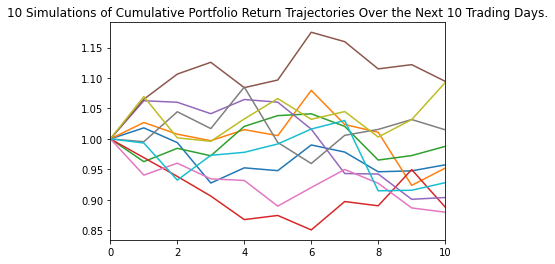

<Figure size 432x288 with 0 Axes>

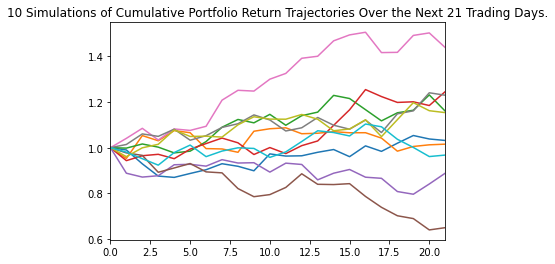

<Figure size 432x288 with 0 Axes>

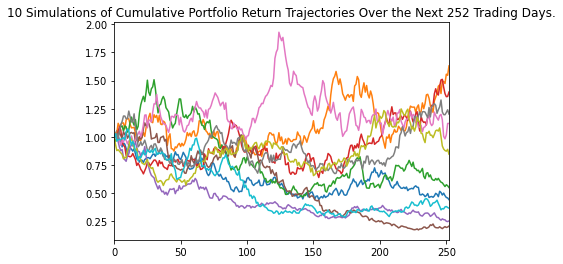

In [72]:
#tickers = ["AAPL", "MSFT", "AMZN", "FB", "GOOGL", "BRK.B", "JNJ", "V", "PG", "SPY"]
analysis = pn.interact(analysis_charts, symbol=tickers)

tab1 = pn.Column(
    "# Simple Moving Average Analysis",
    pn.Row(analysis[0], analysis[1]),
    "## % Return Range For Top 10 S&P500 Stocks",
    pn.Row(risk_chart())
)

sim = pn.interact(sim_charts, symbol=tickers, num_sim=10)
sim[0][1].start = 1
sim[0][1].end = 100

button = pn.widgets.Button(name="Send 10-Days simulation result to your phone", button_type="primary", width=100)
phone_num = pn.widgets.TextInput(value="+1")

tab2 = pn.Column(
    "# Stock Price Projection using Monte Carlo Simulations",
    pn.Row(sim[0], sim[1]),
    pn.Row(phone_num, button)
)

dashboard = pn.Tabs(
    ("# Analysis Tab", tab1),
    ("# Simulation Tab", tab2),
    background = "lightgrey"
)

def send_sms(event):
    twilio_client.api.account.messages.create(
        to=phone_num.value,
        from_=twilio_num,
        body=sim[1][0][0][2].object)
    
button.on_click(send_sms)

print(type(sim[0][1]))

Tabs(background='lightgrey')
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Select(name='symbol', options=['AAPL', 'MSFT', ...], value='AAPL')
            [1] Row
                [0] Column
                    [0] HoloViews(Overlay)
                    [1] HoloViews(Overlay)
        [2] Markdown(str)
        [3] Row
            [0] HoloViews(BoxWhisker)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Select(name='symbol', options=['AAPL', 'MSFT', ...], value='AAPL')
                [1] IntSlider(end=100, name='num_sim', start=1, value=10)
            [1] Row
                [0] Column
                    [0] Column
                        [0] Markdown(str)
                        [1] Matplotlib(Figure)
                        [2] Markdown(str)
                    [1] Column
                        [0] Markdown(str)
                        [1] Matplotlib(Figure)
                        [2] Markdown(str)
                    [2] Column
                        [0] Markdown(str)
                        [1] Matplotlib(Figure)
                        [2] Markdown(str)
        [2] Row
            [0] TextInput(value='+1')
            [1] Button(button_type='primary', name='Send 10-Days s..., width=100)
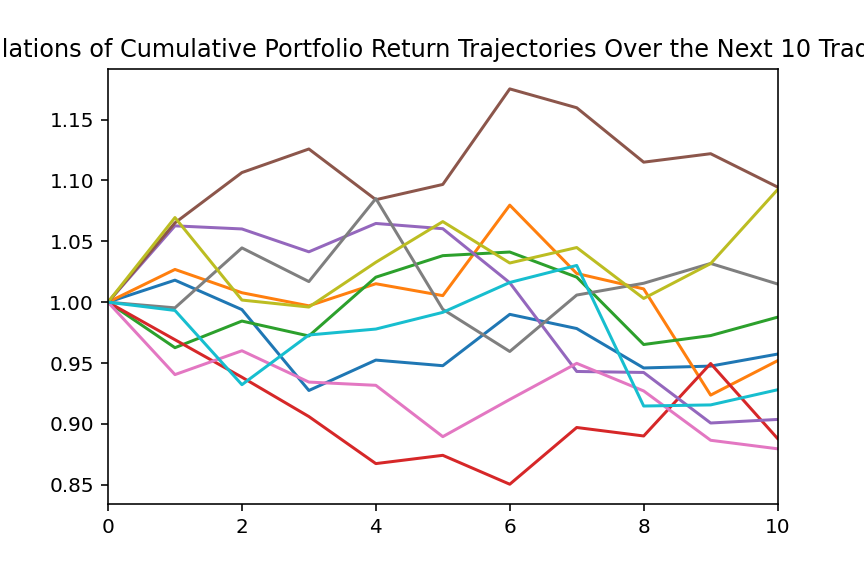
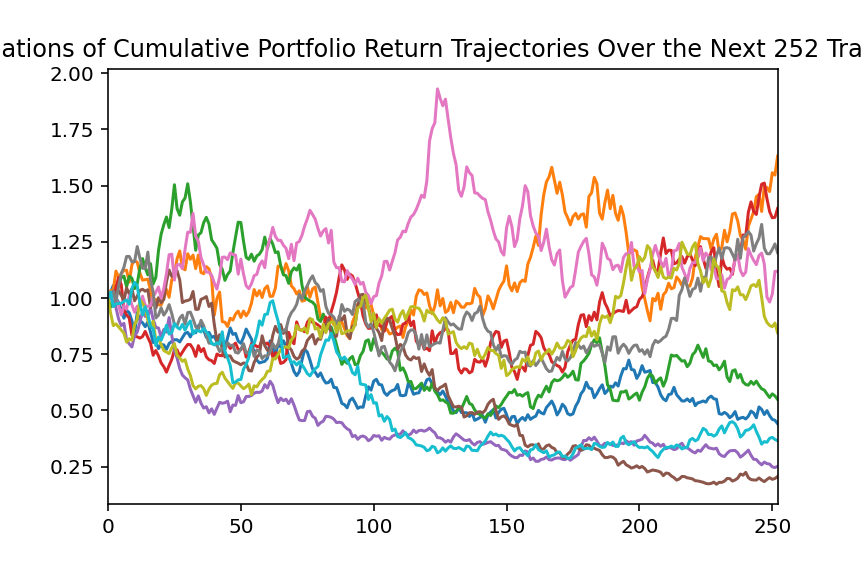
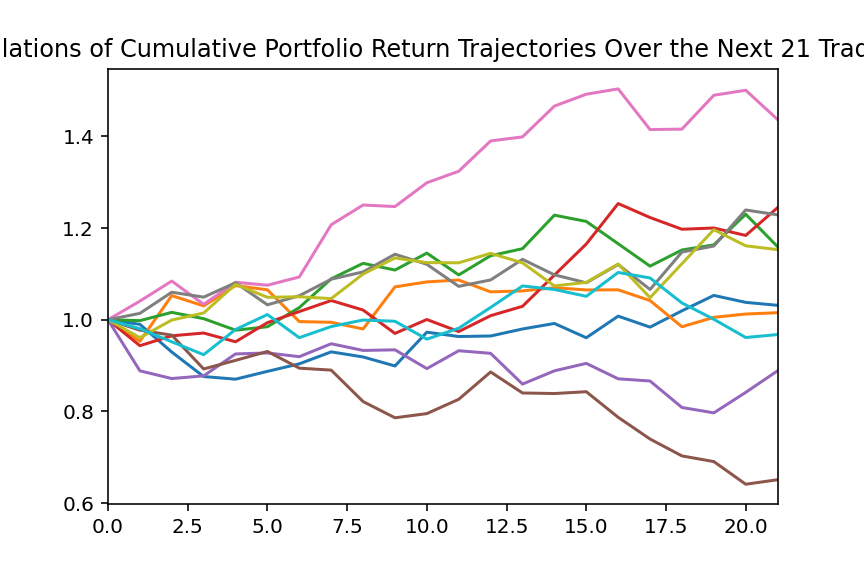

In [73]:
dashboard.servable()